# Logistic Regression


Run analysis using Logistic Regressions and at least 1 other method from class.

Must include:

  - Hyperparameter selection for the logistic regression C parameter

  - Try fitting with l2 (ridge), l1 (lasso), and elastic regularization.

  - Comparison of the methods you used (AUC, Matthew's Correlation Coeff, etc).

You'll need to preprocess the data for the logistic regression by using one-hot encoding (be sure to have a baseline by leaving out a column).

To compare models, first do a train-test split.  Set the test data aside.  Run k-fold cross validation to determine the hyperparameters and evaluate out-of-sample metrics.  Determine which model is projected to do best out of sample based on the k-fold cross validation.  Then, run the models with the selected hyperparameters on your original test dataset.  How well do your metrics hold up on the test set?  Are the model rankings preserved?

## 0. Boilerplate

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('adult.data', names=['age',
              'workclass',
              'fnlwgt',
              'education',
              'education-num',
              'marital-status',
              'occupation',
              'relationship', 'race',
              'sex', 
              'capital-gain',
              'capital-loss',
              'hours-per',
              'native-country', 'y'], index_col = False).drop(['education'], axis = 1)

In [17]:
df.isna().sum() # are there any null values ? -> no 

age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per         0
native-country    0
y                 0
dtype: int64

## 1. One-hot-encoding

In [18]:
test = pd.read_csv('adult.test', names=['age',
              'workclass',
              'fnlwgt',
              'education',
              'education-num',
              'marital-status',
              'occupation',
              'relationship', 'race',
              'sex',
              'capital-gain',
              'capital-loss',
              'hours-per',
              'native-country', 'y'], index_col = False, skiprows = 1).drop(['education'], axis = 1)

test['y'] = test['y'].apply(lambda x: x.replace('.', '').replace(' ', ''))
df['y'] = df['y'].apply(lambda x: x.replace('.', '').replace(' ', ''))

X_train = df.drop(['y'], axis = 1)
y_train = df['y']

X_test = test.drop(['y'], axis =1)
y_test = test['y']

col_trans = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore', # This argument handles categories that are missing in the train that appear in the test
                                                   drop = 'first'), # This drops the first column 
                                    list(X_train.select_dtypes(include = 'O').columns)),
                                    remainder = 'passthrough'
                                     )

I create a pipeline using `make_column_transformer` so the original data is not modified but only inside the `make_pipeline` function. 
Then when I want to predict or fit the model, instead of using the instance of the model as usual, I have to use the instance of the pipeline. This is very benefitial because when I am using new data, I don't have to preprocess it before using the models function, but the data is processes inside the pipeline by using `pipe.predict(test)` instead of `clf.precict(test)`.
The `col_trans` object above does the OneHotEncoder for all the categorical variables, drops the first column of each, and handles unkown categories,i.e., categories that are on the test but not on the train data. Because I need the same transformations for all the regalarized regressions, I can pass it to the `make_pipeline` instance of each type of regression.



# 2. Logistic Regression

## 2.1 Without Regularization






In [19]:
clf_cv = LogisticRegression(random_state = 0, solver='liblinear')

pipecv = make_pipeline(col_trans, clf_cv)
pipecv.fit(X_train, y_train)
preds = pipecv.predict(X_test)

lr_cv = cross_validate(pipecv, X_train, y_train, scoring = ['roc_auc', 'accuracy'])

In [20]:
lr_cv['test_roc_auc'].mean()

0.5876805895275666

I am getting the same value of performance, no matter what value of C I pick. If the purpose of C is not to help increasing the out of sample performance what is the point.

## 2.1. Ridge

For the regularized models I use the `LogisticRegressionCV` function because it finds the optimal hyperparameters with their built in cross-validation.
To indicate that this is a ridge regression, I use penalty `l2`.

In [21]:
clf_ridge = LogisticRegressionCV(solver='liblinear', penalty = 'l2')

pipe_ridge = make_pipeline(col_trans, clf_ridge)
pipe_ridge.fit(X_train, y_train)
preds_ridge = pipe_ridge.predict(X_test)

ridge_cv = cross_validate(pipe_ridge, X_train, y_train, scoring = ['roc_auc', 'accuracy'])
ridge_cv

{'fit_time': array([2.03901696, 1.7744298 , 1.80312395, 1.80513191, 1.73180008]),
 'score_time': array([0.03906608, 0.03927016, 0.0331552 , 0.03427005, 0.033535  ]),
 'test_roc_auc': array([0.58471155, 0.60428947, 0.58497932, 0.57697036, 0.59119537]),
 'test_accuracy': array([0.7968678 , 0.79407248, 0.80006143, 0.79530098, 0.7997543 ])}

In [22]:
ridge_cv['test_roc_auc'].mean()

0.5884292129530797


## 2.2. Lasso

To indicate that the regression is a lasso regression, I use the penalty `l1`.

In [23]:
clf_lasso = LogisticRegressionCV(solver='liblinear', penalty = 'l1')

pipe_lasso = make_pipeline(col_trans, clf_lasso)
pipe_lasso.fit(X_train, y_train)
preds_lasso = pipe_lasso.predict(X_test)

lasso_cv = cross_validate(pipe_lasso, X_train, y_train, scoring = ['roc_auc', 'accuracy'])

In [24]:
lasso_cv['test_roc_auc'].mean()

0.9047040977027804

## 2.3 Elastic Net



In [25]:
clf_en = LogisticRegressionCV(random_state = 0, solver='saga', penalty = 'elasticnet', l1_ratios = [0, 0.2, 0.4, 0.6 , 0.8, 1],\
                              max_iter = 8000)

pipe_en = make_pipeline(col_trans, clf_en)
pipe_en.fit(X_train, y_train)
preds_en = pipe_en.predict(X_test)

elastic_cv = cross_validate(pipe_en, X_train, y_train, scoring = ['roc_auc', 'accuracy'])

In [26]:
elastic_cv['test_roc_auc'].mean()

0.6274460060756591

## 3. Naive Bayes

As an alternative to logistic regression, I use a Naive Bayes Classifier.
I need to convert all the variables into integers so the classifier works properly. This is what `le = preprocessing.LabelEncoder()` does.
I also have to bin continuous variables, with I do with the `pd.cut()` function in pandas.

In [27]:
le = preprocessing.LabelEncoder()

def bining(df):
  '''
  Functions that bins all the numerical variables and bins them
  '''
  for col in df.select_dtypes(exclude = ['O']).columns:
    df[col] = pd.cut(df[col], bins = 10)
  return df
  
X_train['type'] = 1
X_test['type'] = 0

X_full = pd.concat([X_train, X_test])

min_categories=X_full.nunique()

In [28]:
# Create bins
X_full = bining(X_full)

X_NB = X_full.apply(lambda x: le.fit_transform(x))

# Split
X_train_NB = X_NB[X_NB['type'] ==  1]
X_test_NB = X_NB[X_NB['type'] == 0]

y_train_NB = le.fit_transform(y_train)
y_test_NB = le.fit_transform(y_test)

In [29]:
clf_nb = CategoricalNB(min_categories=X_train.nunique())
# drop type cols
X_train = X_train.drop(['type'], axis = 1)
X_test = X_test.drop(['type'], axis = 1)

clf_nb.fit(X_train_NB, y_train_NB)

naive_scores = cross_validate(clf_nb, X_train_NB, y_train_NB, scoring = ['roc_auc', 'accuracy'])

In [30]:
naive_scores['test_roc_auc'].mean()

0.8932793144599438

## Model Comparison

According to the cross-validation scores in the train data,  the best model is lasso (auc = 0.9), followed  by naive bayes (auc = 8.89), then ridge and the unregularized regression have very similar auc scores (around 0.58).

Using the testing data, I show the roc curves  below.
The worst models are the un-regularized logistic regression (ULR) and the ridge regression, which is not visible in the graph because the line from the ULR completely overlays the ridge line. This means that the ridge regularization is not working for increasing prediction. This is very surprising. Discussion with Ben, I found that all of his regressions are pretty much similar in terms of prediction. The fact that my results are so different from his could be because in his pipeline he is scaling the X variables or if one of us made a mistake. If is the first, then this shows the importance of scaling the variables: the gain in accuracy is very big. 

The best regression are lasso and the Naive Bayes classifier. The later is slightly worst, but it does not require parameter tuning to achieve such accuracy. 

The results form the test roc curves and the cross-validation scores show that the model rankings are maintaned. The best model for prediction in this case is the lasso regression.

Text(0.5, 1.0, 'ROC curve for all regressions')

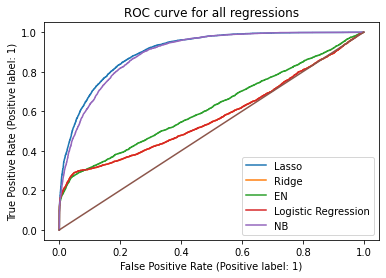

In [31]:
roc_plot = metrics.plot_roc_curve(pipe_lasso, X_test, y_test, label = 'Lasso')
metrics.plot_roc_curve(pipe_ridge, X_test, y_test, ax = roc_plot.ax_, label = 'Ridge');
metrics.plot_roc_curve(pipe_en, X_test, y_test, ax = roc_plot.ax_, label = 'EN');
metrics.plot_roc_curve(pipecv, X_test, y_test, ax = roc_plot.ax_, label = 'Logistic Regression');
metrics.plot_roc_curve(clf_nb, X_test_NB, y_test_NB, ax = roc_plot.ax_, label = 'NB');
sns.lineplot(x = np.linspace(0, 1, 100), y = np.linspace(0, 1, 100))
plt.title('ROC curve for all regressions')